
# Case Study 5: Bayesian Neural Network

Adapted from https://num.pyro.ai/en/stable/examples/bnn.html , we first see the NumPyro implementation and then SOGA.


In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time

from utils import get_data, neg_log_likelihood_one, generate_bnn_code_relu, generate_bnn_code_observe, generate_bnn_parameters, optimize, make_dataset, append_observe_block
import vi_model
from parallel_loss import run_parallel

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
from pyro.distributions import constraints
import pyro.distributions as dist

torch.set_default_dtype(torch.float32)
import time

['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src']
['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src']
['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages'

### Training the BNN with VI in Pyro

X.shape torch.Size([500, 1, 1]) Y.shape torch.Size([500, 1, 1])


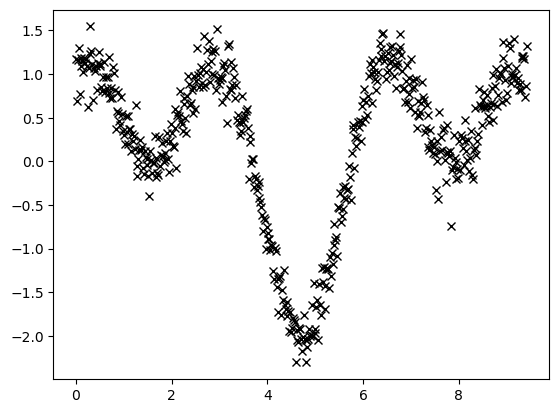

In [12]:
args = [100, 2, 4]
N = 500
N_test = 50 
D_X = 2 
D_H = 4
n_hidden = 2
n_neurons = 3
#X, Y, X_test = get_data(N=N, D_X=D_X)

X, Y, X_test, Y_test = make_dataset(func_id=1, N=N, N_test=N_test, sigma=0.2)

X = X.unsqueeze(-1)
Y = Y.unsqueeze(-1)

print('X.shape', X.shape, 'Y.shape', Y.shape)
plt.plot(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy(), "kx")

Step 0 - Loss: 672927.6250
Step 20000 - Loss: 20345.8298
Step 40000 - Loss: 18766.7130
Step 60000 - Loss: 18766.7342
Step 80000 - Loss: 18764.2617
Step 100000 - Loss: 18765.6617
Step 120000 - Loss: 18765.2026
Step 140000 - Loss: 18762.6821
Step 160000 - Loss: 18765.5637
Step 180000 - Loss: 18767.3247
Training complete!


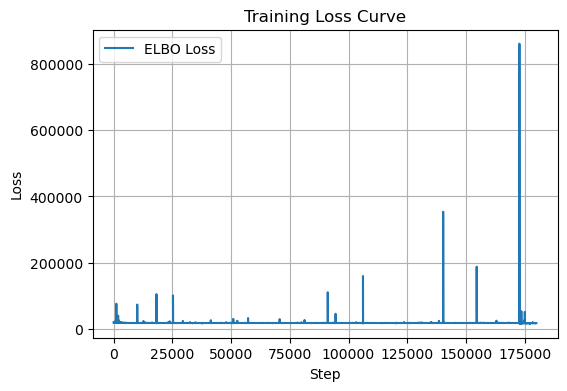

Training time: 448.03263902664185


In [ ]:
# Variational Inference
torch.set_default_dtype(torch.float32)

start = time.time()
losses = vi_model.train_vi(vi_model.model, vi_model.guide, X, Y, n_hidden, n_neurons, num_steps = 2003000, lr = 0.01)
end = time.time()
print("Training time:", end - start)

In [15]:
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.detach().numpy()}")

w1_loc: [[-0.43702936 -0.74222004 -1.2154069 ]]
w1_scale: [[0.00231818 0.33406472 0.37704527]]
b1_loc: [ 1.8282698 -0.9724118 -0.6645407]
b1_scale: [0.00868065 0.641733   0.3870148 ]
w2_loc: [[-0.90595806  1.6488545  -0.89226884]
 [-0.6368052   0.32357964 -0.15668239]
 [-0.07271482 -0.15202405 -0.01408102]]
w2_scale: [[0.3388958  0.0208813  0.31518072]
 [0.55905443 0.5869228  0.9135933 ]
 [0.93120015 0.92505676 0.95224625]]
b2_loc: [-1.5402366   0.01065671 -1.608358  ]
b2_scale: [0.41746822 0.01334623 0.33559126]
w_out_loc: [[-0.24047947]
 [ 0.2931507 ]
 [-0.0777332 ]]
w_out_scale: [[0.5780777 ]
 [0.00354116]
 [0.76391023]]
b_out_loc: [0.02171966]
b_out_scale: [0.00494263]


In [16]:
Y_train = vi_model.predict_vi(X, pyro.param, n_hidden, n_neurons)

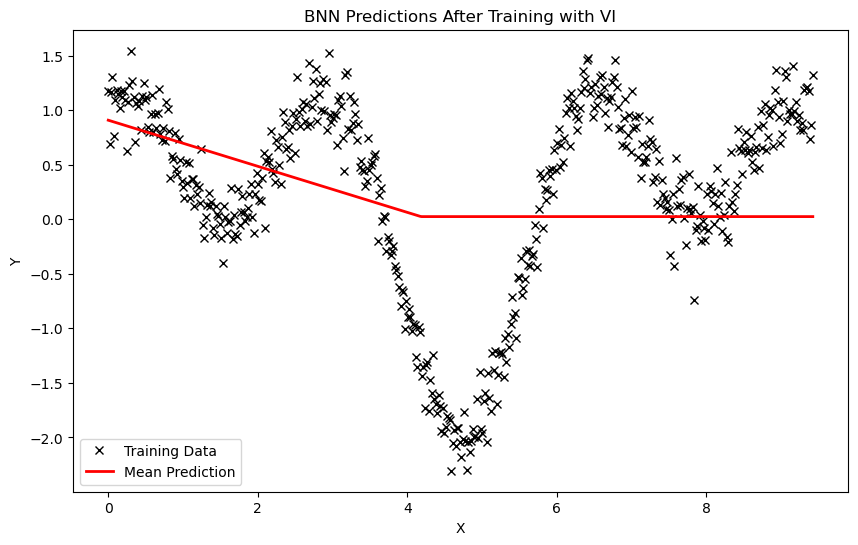

In [17]:


# Visualize the results of the BNN trained using Variational Inference
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy(), "kx", label="Training Data")

# Predictive mean after training

# Plot mean prediction
plt.plot(X.squeeze(-1).numpy(), Y_train.squeeze(-1).detach().numpy(), "r", lw=2.0, label="Mean Prediction")

# Add labels, legend, and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("BNN Predictions After Training with VI")
plt.legend()

# Show the plot
plt.show()

In [7]:
#compute r^2 on the test set
Y_test_pred = vi_model.predict_vi(X_test, pyro.param, n_hidden, n_neurons)
ss_res = torch.sum((Y_test - Y_test_pred)**2)
ss_tot = torch.sum((Y_test - torch.mean(Y_test))**2)
r2 = 1 - ss_res/ss_tot
print(f"R^2 on test set: {r2.item():.4f}")

R^2 on test set: -0.0226


### Sanity check on SOGA program

We use the parameters found by VI in SOGA to check that the BNN is correctly encoded

In [8]:
def extract_vi_parameters(n_hidden, n_neurons, param_store):
    """
    Extract Pyro variational parameters and map them into a dictionary
    consistent with the DSL code generated by `generate_bnn_code`.

    Supports two naming conventions for the output layer:
      - "w{n_hidden+1}_loc", "b{n_hidden+1}_loc"
      - "w_out_loc", "b_out_loc"
    """

    vi_pars = {}
    w_counter = 1
    b_counter = 1

    # --- Hidden layers ---
    in_dim = 1
    for layer in range(n_hidden):
        W_mean = param_store[f"w{layer+1}_loc"].detach().numpy()
        W_std  = param_store[f"w{layer+1}_scale"].detach().numpy()
        b_mean = param_store[f"b{layer+1}_loc"].detach().numpy()
        b_std  = param_store[f"b{layer+1}_scale"].detach().numpy()

        for i in range(in_dim):        # inputs
            for j in range(n_neurons): # neurons
                vi_pars[f"muw{w_counter}"]    = torch.tensor(W_mean[i, j], requires_grad=True)
                vi_pars[f"sigmaw{w_counter}"] = torch.tensor(W_std[i, j], requires_grad=True)
                w_counter += 1

        for j in range(n_neurons):     # biases
            vi_pars[f"mub{b_counter}"]    = torch.tensor(b_mean[j], requires_grad=True)
            vi_pars[f"sigmab{b_counter}"] = torch.tensor(b_std[j], requires_grad=True)
            b_counter += 1

        in_dim = n_neurons

    # --- Output layer ---
    # check which naming scheme is used
    if f"w{n_hidden+1}_loc" in param_store:
        W_mean = param_store[f"w{n_hidden+1}_loc"].detach().numpy()
        W_std  = param_store[f"w{n_hidden+1}_scale"].detach().numpy()
        b_mean = param_store[f"b{n_hidden+1}_loc"].detach().numpy()
        b_std  = param_store[f"b{n_hidden+1}_scale"].detach().numpy()
    else:  # use "w_out", "b_out"
        W_mean = param_store["w_out_loc"].detach().numpy()
        W_std  = param_store["w_out_scale"].detach().numpy()
        b_mean = param_store["b_out_loc"].detach().numpy()
        b_std  = param_store["b_out_scale"].detach().numpy()

    for i in range(in_dim):
        vi_pars[f"muw{w_counter}"]    = torch.tensor(W_mean[i, 0], requires_grad=True)
        vi_pars[f"sigmaw{w_counter}"] = torch.tensor(W_std[i, 0], requires_grad=True)
        w_counter += 1

    vi_pars[f"mub{b_counter}"]    = torch.tensor(b_mean[0], requires_grad=True)
    vi_pars[f"sigmab{b_counter}"] = torch.tensor(b_std[0], requires_grad=True)
    b_counter += 1

    return vi_pars


In [ ]:
from pyro import get_param_store

param_store = get_param_store()
vi_pars = extract_vi_parameters(n_hidden, n_neurons, param_store)
print(vi_pars)

{'muw1': tensor(-0.1621, requires_grad=True), 'sigmaw1': tensor(0.1335, requires_grad=True), 'muw2': tensor(-0.0849, requires_grad=True), 'sigmaw2': tensor(0.1980, requires_grad=True), 'muw3': tensor(0.2786, requires_grad=True), 'sigmaw3': tensor(0.2437, requires_grad=True), 'muw4': tensor(0.0441, requires_grad=True), 'sigmaw4': tensor(0.2431, requires_grad=True), 'muw5': tensor(-0.0400, requires_grad=True), 'sigmaw5': tensor(0.3305, requires_grad=True), 'mub1': tensor(-1.0843, requires_grad=True), 'sigmab1': tensor(0.4642, requires_grad=True), 'mub2': tensor(-1.3465, requires_grad=True), 'sigmab2': tensor(0.3237, requires_grad=True), 'mub3': tensor(-1.1760, requires_grad=True), 'sigmab3': tensor(0.4663, requires_grad=True), 'mub4': tensor(-0.8700, requires_grad=True), 'sigmab4': tensor(0.5440, requires_grad=True), 'mub5': tensor(-0.8038, requires_grad=True), 'sigmab5': tensor(0.4238, requires_grad=True), 'muw6': tensor(-0.2938, requires_grad=True), 'sigmaw6': tensor(0.7443, requires_g

: 

In [3]:
torch.set_default_dtype(torch.float64)

# This is the X vector used in the script
X_soga = torch.tensor(X.squeeze(-1).squeeze(-1).numpy(), dtype=torch.float64)

soga_code = generate_bnn_code(n=n_hidden, m=n_neurons)  # two hidden layers, 3 neurons each


compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)


y_means = []
loss = 0.
for j in range(len(X.squeeze(-1).squeeze(-1))):
    xj = X.squeeze([-1,1])[j]
    vi_pars['x'] = xj.requires_grad_(False)

    current_dist = start_SOGA(cfg, vi_pars, pruning='ranking')
    y_means.append(current_dist.gm.mean()[current_dist.var_list.index('y')].detach().numpy())
    loss += neg_log_likelihood_one(torch.tensor(Y.squeeze(-1)[j], dtype=torch.float64 ), current_dist)   

#output_dist = start_SOGA(cfg, vi_pars, pruning='ranking') #params_dict 


plt.plot(X.numpy().flatten(), Y.numpy().flatten(), "kx")
#plt.plot(X.numpy().flatten(), Y_samples_mean, "blue", ls="solid", lw=2.0, label='sampling')
plt.plot(X.squeeze(-1).numpy(), Y_train.squeeze(-1).detach().numpy(), "r", lw=2.0, label="variational inference")
plt.plot(X_soga.numpy().flatten(), y_means, "green", ls="solid", lw=2.0, label='SOGA')

plt.legend()

print("Loss SOGA:", loss.item())


NameError: name 'vi_pars' is not defined

### Optimization in SOGA

We use a different script in which the std of the weights are fixed (if not the loss is better for higher stds).
Moreover we add noise to the output to avoid infinite loss

In [9]:
torch.set_default_dtype(torch.float64)

#soga_code = generate_bnn_code_relu(n=n_hidden, m=n_neurons)
soga_code = generate_bnn_code_observe(n=n_hidden, m=n_neurons)
#soga_code = append_observe_block(soga_code, "x > 8", "y > 0")
constraint_str = """
x = _x;
if x > 4. {
    if x < 5. {
        observe(y < -1);
    } else {
        skip;
    } end if;
} else {
    skip;
} end if;"""

#soga_code = soga_code + "\n" + constraint_str
bnn_one_pars = generate_bnn_parameters(n=n_hidden, m=n_neurons)

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

#bnn_one_pars = {'muw1':1., 'muw2': -1., 'muw3': 1., 'muw4': -1., 'muw5': -1., 'muw6': 1., 'muw7': -1., 'muw8': -1.,  
            #'mub1': -1., 'mub2': -1., 'mub3': -1., 'mub4': 1., 'mub5': 1.,
            #'sigmaw1': 0.1, 'sigmaw2': 0.1, 'sigmaw3': 0.1, 'sigmaw4': 0.1, 'sigmaw5': 0.1, 'sigmaw6': 0.1, 'sigmaw7': 0.1, 'sigmaw8': 0.1,
            #'sigmab1': 0.1, 'sigmab2': 0.1, 'sigmab3': 0.1, 'sigmab4': 0.1, 'sigmab5': 0.1,}

bnn_one_pars = optimize(bnn_one_pars, cfg, X, Y, steps = 2000, lr = 0.01)


 loss: 309.61219018122034muw1: 0.7785924264991112 sigmaw1: 0.09000000000096385 mub1: -0.14102505306044488 sigmab1: 0.09000000001764334 muw2: -0.9114943764191665 sigmaw2: 0.10999999999958926 mub2: -0.6129346125295445 sigmab2: 0.10999999999623346 muw3: -0.5341309134208169 sigmaw3: 0.1099999999898443 mub3: 0.1867962509436855 sigmab3: 0.10999999995489046 muw4: 0.14055149907756714 sigmaw4: 0.1 muw5: -0.833582320310521 sigmaw5: 0.1 muw6: 0.551772242896833 sigmaw6: 0.1 mub4: -0.19350495355143316 sigmab4: 0.10999999999565169 muw7: -0.5608334805733066 sigmaw7: 0.1 muw8: 0.4798143052621775 sigmaw8: 0.1 muw9: 0.6116866855518475 sigmaw9: 0.1 mub5: -0.6790187706829329 sigmab5: 0.10999999999848425 muw10: -0.8955335207952062 sigmaw10: 0.10999999999852604 muw11: -0.22842016870623522 sigmaw11: 0.1099999999993968 muw12: 0.5142360107116489 sigmaw12: 0.10999999927188127 mub6: -0.569148987704778 sigmab6: 0.10999999991486709 muw13: 0.2044116155881498 sigmaw13: 0.10999999999915094 muw14: -0.33770491758118326

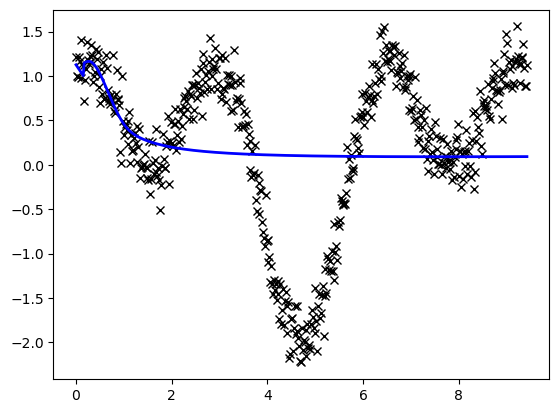

In [10]:
y_means = []
for j in range(len(Y.squeeze([-1,1]))):
    yj = Y.squeeze([1])[j].to(torch.float64)
    xj = X.squeeze([-1,1])[j]
    bnn_one_pars['x'] = xj.requires_grad_(False)

    current_dist = start_SOGA(cfg, bnn_one_pars, pruning='ranking')
    y_means.append(current_dist.gm.mean()[current_dist.var_list.index('y')].detach().numpy())

# plot training data
plt.plot(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy(), "kx")
# plot 90% confidence level of predictions
#plt.fill_between(X.numpy().flatten(), percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
plt.plot(X.numpy().flatten(), y_means, "blue", ls="solid", lw=2.0)
#ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")
plt.show()

In [11]:

Y_test_pred = []

X_test = X_test.unsqueeze(-1)
Y_test = Y_test.unsqueeze(-1)
for j in range(len(Y_test.squeeze([-1,1]))):
    yj = Y_test.squeeze([1])[j].to(torch.float64)
    xj = X_test.squeeze([-1,1])[j]
    bnn_one_pars['x'] = xj.requires_grad_(False)

    current_dist = start_SOGA(cfg, bnn_one_pars, pruning='ranking')
    Y_test_pred.append(current_dist.gm.mean()[current_dist.var_list.index('y')].detach())

ss_res = torch.sum((Y_test.squeeze() - torch.tensor(Y_test_pred))**2)
ss_tot = torch.sum((Y_test.squeeze() - torch.mean(Y_test.squeeze()))**2)
r2 = 1 - ss_res/ss_tot
print(f"R^2 on test set: {r2.item():.4f}")

R^2 on test set: 0.0751
